In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from time import perf_counter
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
# Load the GPT-2 model and tokenizer from Hugging Face
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
# Text Generation

prompt = "The quick brown fox jumps over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 18045,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [5]:
# Passing the inputs to the model and getting the logits to find the most likely next token

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
logits.shape

torch.Size([1, 7, 50257])

In [6]:
# The logits are a 2D tensor, where the first dimension is the batch size (1 in this case) and the second dimension is the sequence length. 
# We can get the logits for the last token in the sequence. 

last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [7]:
# Decoding the next token

tokenizer.decode(next_token_id)

' fence'

In [8]:
# 10 most likely next tokens
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' wall',
 ' table',
 ' top',
 ' ground',
 ' bar',
 ' railing',
 ' tree',
 ' fox']

In [9]:
# Concatenate the prompt(input) and the predicted token to get the new input sequence
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    )
}


print(next_inputs)

{'input_ids': tensor([[  464,  2068,  7586, 21831, 18045,   625,   262, 13990]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [10]:
# Helper function for text generation

def generate_token(inputs):
    
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()

    return next_token_id


generated_tokens = []
next_inputs = inputs
durations_s = []

for _ in range(10):
    t0 = perf_counter()
    next_token_id = generate_token(next_inputs)
    durations_s += [perf_counter() - t0]

    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1
        ),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1
        )
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)


print(f"{sum(durations_s):.3f} seconds")
print(generated_tokens)

0.843 seconds
[' fence', ' and', ' runs', ' into', ' the', ' bushes', '.', '\n', '\n', '"']


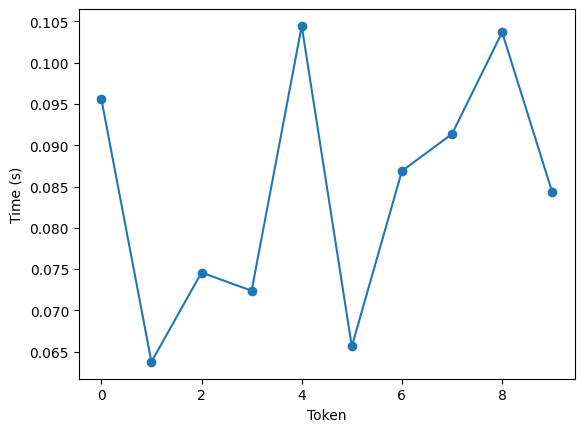

In [11]:
# Generation time for each token

plt.plot(durations_s, marker="o")
plt.xlabel("Token")
plt.ylabel("Time (s)")
plt.show()

In [13]:
# Speeding up text generation with KV-caching

def generate_token_with_past(inputs):

    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    
    return next_token_id, outputs.past_key_values


generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = perf_counter()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s += [perf_counter() - t0]

    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1
        ),
        "past_key_values": past_key_values
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)


print(f"{sum():.3f} seconds")
print(generated_tokens)

0.570 seconds
[' fence', ' and', ' runs', ' into', ' the', ' bushes', '.', '\n', '\n', '"']


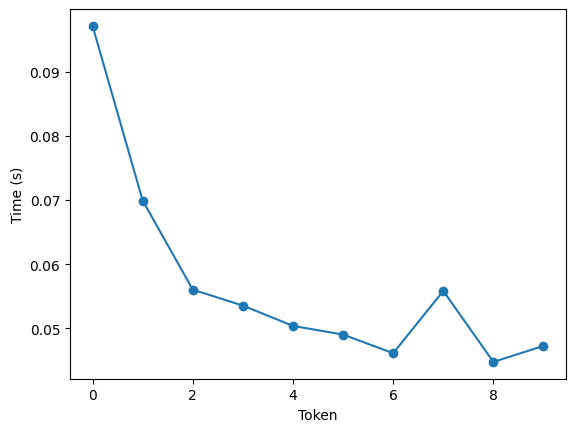

In [15]:
# Generation time for each token
plt.plot(durations_cached_s, marker="o")
plt.xlabel("Token")
plt.ylabel("Time (s)")
plt.show()

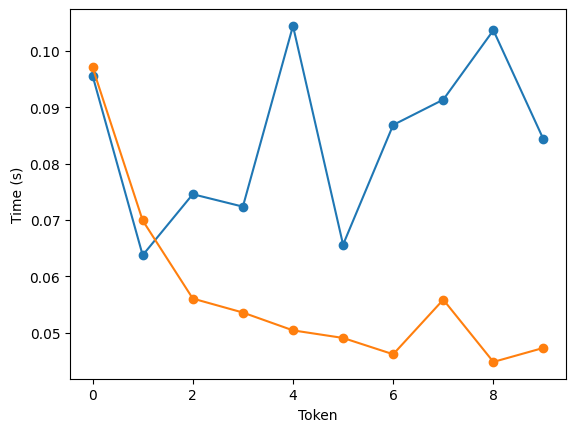

In [16]:
# Generation time variation for each token 
plt.plot(durations_s, marker="o")
plt.plot(durations_cached_s, marker="o")
plt.xlabel("Token")
plt.ylabel("Time (s)")
plt.show()